# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'median_pre_discussion_error',
   'median_post_discussion_error',
   'median_pre_discussion_error_pct',
   'median_post_discussion_error_pct',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'reverse_mean_post_discussion_error_pct',
   'reverse_median_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   '

# Repeated k-Fold Cross-Validation

In [3]:
def repeated_kfold_cv(model, k = 10, seed = 19104):

    """
    Parameters:
    - model: The model we are doing k-fold CV for
    - k: the number of fols (defaults to 10)
    - seed: the random seed (defaults to 19104)

    @returns the following, pouplated with data from the k0=-fold CV:
    - train_metrics: a dataframe to store all the training metrics
    - test_metrics: a dataframe to store all the test set metrics (we will universally use a 80-20 train-test split)
    - shap_df: a dataframe to store the Shapley value summaries for each fold
    - shap_correlation_df: a dataframe to store how the Shapley values correlate with feature values for each fold
    """

    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    train_metrics = pd.DataFrame(columns=metrics)
    test_metrics = pd.DataFrame(columns=metrics)

    for i in range(len(random_states_list)):
        # store the model metrics for each iteration
        metrics = model.evaluate_model(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i], visualize_model = False)
        train_metrics = train_metrics.append(metrics['train'], ignore_index=True)
        test_metrics = test_metrics.append(metrics['val'], ignore_index=True)
    
        # store the shap summary for each iteration

        try:     
            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)
        except NameError:
            # we haven't defined these yet; we're in the first iteration!
            # we have to do this becaus model.X does not show up until after the first case when evaluate_model is called
            shap_df = pd.DataFrame({'feature': model.X.columns})
            shap_correlation_df = pd.DataFrame({'feature': model.X.columns})

            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)


    shap_df.set_index('feature', inplace=True)
    shap_correlation_df.set_index('feature', inplace=True)

    return(shap_df, shap_correlation_df, train_metrics, test_metrics)

In [4]:
def get_repeated_kfold_cv_summary(shap_df, shap_correlation_df, train_metrics, test_metrics):
    """
    Get the means of the repeated k-fold cross validation across all relevant metrics.
    """
    shap_means = shap_df.mean(axis=1).sort_values(ascending = False)
    shap_cor_means = shap_correlation_df.mean(axis=1).reindex(index = shap_means.index)
    train_means = train_metrics.mean()
    test_means = test_metrics.mean()

    return(shap_means, shap_cor_means, train_means, test_means)

In [5]:
time_points = ["25%", "50%", "75%", "100%"]

In [6]:
NUM_TOP_FEATURES = 5

In [7]:
def plot_important_features_over_time(merged_df, color_palette, title="Top Feature Importance Over Time", filename="./figures/feature_importance.png"):
    # Transpose the DataFrame and sort by each time point
    top_features = merged_df.apply(lambda x: x.nlargest(NUM_TOP_FEATURES))

    non_na_feature = top_features.dropna()
    na_feature = top_features.loc[~top_features.index.isin(top_features.dropna().index)].fillna(0)

    # Plot a line chart to show how the top feature values change over time
    if not non_na_feature.empty and not na_feature.empty:
        ax = non_na_feature.T.plot(kind='line', marker='o', linewidth=3, color=color_palette)
        na_feature.T.plot(kind='line', marker='o', linestyle='--', linewidth=3, ax=ax, color=color_palette)  # Use the same axis for dashed lines
    elif non_na_feature.empty:
        ax = na_feature.T.plot(kind='line', marker='o', linestyle='--', linewidth=3, color=color_palette)
    elif na_feature.empty:
        ax = non_na_feature.T.plot(kind='line', marker='o', linewidth=3, color=color_palette)

    plt.ylabel('Importance (SHAP value)', size=14)
    plt.xlabel('Percent of Chat Messages (Chronological)', size=14)
    plt.title(title, fontsize=18, fontweight="bold")
    plt.xticks(range(len(time_points)), time_points, fontsize=14)

    # Update legend with custom color mapping
    legend_labels = ax.get_legend().get_texts()
    for label in legend_labels:
        feature_name = label.get_text()

    plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1.05, 1), bbox_transform=ax.transAxes)

    plt.savefig(filename, dpi=1200, bbox_inches='tight')
    plt.show()

# Multi-Task Joint Model

### Joint Model (standardizing features _across_ tasks)

In [8]:
joint_model = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "gurcay", "dat"])
joint_model.select_target(target=["majority_pct", "efficiency", "efficiency", "reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct", "efficiency"])
joint_model.define_model(model_type = 'rf')

In [9]:
# Call the Repeated k-Fold CV
joint_shap, joint_shap_cor, joint_train_metrics, joint_test_metrics = repeated_kfold_cv(joint_model)
joint_shap_means, joint_shap_cor_means, joint_train_means, joint_test_means = get_repeated_kfold_cv_summary(joint_shap, joint_shap_cor, joint_train_metrics, joint_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


75% data

In [10]:
joint_model75 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "gurcay", "dat"], output_dir = '../output/first_75/')
joint_model75.select_target(target=["majority_pct", "efficiency", "efficiency", "reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct", "efficiency"])
joint_model75.define_model(model_type = 'rf')

In [11]:
# Call the Repeated k-Fold CV
joint_shap75, joint_shap_cor75, joint_train_metrics75, joint_test_metrics75 = repeated_kfold_cv(joint_model)
joint_shap_means75, joint_shap_cor_means75, joint_train_means75, joint_test_means75 = get_repeated_kfold_cv_summary(joint_shap75, joint_shap_cor75, joint_train_metrics75, joint_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


50% data

In [12]:
joint_model50 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "gurcay", "dat"], output_dir = '../output/first_50/')
joint_model50.select_target(target=["majority_pct", "efficiency", "efficiency", "reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct", "efficiency"])
joint_model50.define_model(model_type = 'rf')

In [13]:
# Call the Repeated k-Fold CV
joint_shap50, joint_shap_cor50, joint_train_metrics50, joint_test_metrics50 = repeated_kfold_cv(joint_model50)
joint_shap_means50, joint_shap_cor_means50, joint_train_means50, joint_test_means50 = get_repeated_kfold_cv_summary(joint_shap50, joint_shap_cor50, joint_train_metrics50, joint_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


25% Data

In [14]:
joint_model25 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "gurcay", "dat"], output_dir = '../output/first_25/')
joint_model25.select_target(target=["majority_pct", "efficiency", "efficiency", "reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct", "efficiency"])
joint_model25.define_model(model_type = 'rf')

In [15]:
# Call the Repeated k-Fold CV
joint_shap25, joint_shap_cor25, joint_train_metrics25, joint_test_metrics25 = repeated_kfold_cv(joint_model25)
joint_shap_means25, joint_shap_cor_means25, joint_train_means25, joint_test_means25 = get_repeated_kfold_cv_summary(joint_shap25, joint_shap_cor25, joint_train_metrics25, joint_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


Plot the Model Summaries

In [16]:
NUM_COLORS = 19104*len(joint_model.X.columns)

In [17]:
# color dictionary
def generate_color(feature_name):
    hashed = hash(feature_name) % NUM_COLORS
    hue = hashed / 1000.0
    saturation = (hashed % NUM_COLORS) / NUM_COLORS  # Vary the saturation within a range (0.7 to 1.0)
    value = 0.8
    color_rgb = colorsys.hsv_to_rgb(hue, saturation, value)
    return color_rgb

# Create a color mapping dictionary
color_mapping = {feature_name: generate_color(feature_name) for feature_name in joint_model.X.columns}

In [18]:
merged_df = pd.concat([joint_shap_means25, joint_shap_means50, joint_shap_means75, joint_shap_means], keys = time_points, axis=1)

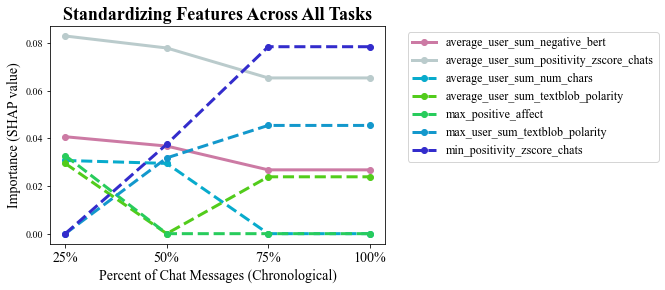

In [19]:
plot_important_features_over_time(merged_df, color_mapping, "Standardizing Features Across All Tasks", "./figures/across_task_std_btwn_features.svg")

In [20]:
# look at direction of impact
pd.concat([joint_shap_cor_means25, joint_shap_cor_means50, joint_shap_cor_means75, joint_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
average_user_sum_positivity_zscore_chats,0.673411,0.661576,0.648979,0.648979
average_user_sum_negative_bert,-0.273890,-0.268660,-0.292865,-0.292865
max_positive_affect,-0.310707,NaN,NaN,NaN
average_user_sum_num_chars,-0.514872,-0.504570,-0.497654,-0.497654
average_user_sum_textblob_polarity,-0.830441,-0.821100,-0.818659,-0.818659
max_user_sum_num_chars,-0.528118,-0.542985,-0.522702,-0.522702
Q7type_7_battle,-0.711625,-0.728766,-0.671145,-0.671145
average_user_sum_cognitive_mech,-0.619875,-0.661698,-0.652289,-0.652289
max_user_sum_negative_bert,-0.319396,-0.375082,-0.332182,-0.332182


### Joint Model (standardizing features _within_ tasks)

100% of Data

In [21]:
# standardize_within defaults to false, so let's check what happens when we change it to true
joint_model_std_within = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "gurcay", "dat"], standardize_within= True)
joint_model_std_within.select_target(target=["majority_pct", "efficiency", "efficiency", "reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct", "efficiency"])
joint_model_std_within.define_model(model_type = 'rf')

In [22]:
# Call the Repeated k-Fold CV
joint_sw_shap, joint_sw_shap_cor, joint_sw_train_metrics, joint_sw_test_metrics = repeated_kfold_cv(joint_model_std_within)
joint_sw_shap_means, joint_sw_shap_cor_means, joint_sw_train_means, joint_sw_test_means = get_repeated_kfold_cv_summary(joint_sw_shap, joint_sw_shap_cor, joint_sw_train_metrics, joint_sw_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


75% of Data

In [23]:
joint_model_std_within75 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "gurcay", "dat"], standardize_within= True, output_dir = '../output/first_75/')
joint_model_std_within75.select_target(target=["majority_pct", "efficiency", "efficiency", "reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct", "efficiency"])
joint_model_std_within75.define_model(model_type = 'rf')

In [24]:
# Call the Repeated k-Fold CV
joint_sw_shap75, joint_sw_shap_cor75, joint_sw_train_metrics75, joint_sw_test_metrics75 = repeated_kfold_cv(joint_model_std_within75)
joint_sw_shap_means75, joint_sw_shap_cor_means75, joint_sw_train_means75, joint_sw_test_means75 = get_repeated_kfold_cv_summary(joint_sw_shap75, joint_sw_shap_cor75, joint_sw_train_metrics75, joint_sw_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


50% of Data

In [25]:
joint_model_std_within50 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "gurcay", "dat"], standardize_within= True, output_dir = '../output/first_50/')
joint_model_std_within50.select_target(target=["majority_pct", "efficiency", "efficiency", "reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct", "efficiency"])
joint_model_std_within50.define_model(model_type = 'rf')

In [26]:
# Call the Repeated k-Fold CV
joint_sw_shap50, joint_sw_shap_cor50, joint_sw_train_metrics50, joint_sw_test_metrics50 = repeated_kfold_cv(joint_model_std_within50)
joint_sw_shap_means50, joint_sw_shap_cor_means50, joint_sw_train_means50, joint_sw_test_means50 = get_repeated_kfold_cv_summary(joint_sw_shap50, joint_sw_shap_cor50, joint_sw_train_metrics50, joint_sw_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


25% of Data

In [27]:
joint_model_std_within25 = ModelBuilder(dataset_names = ["juries", "csop", "csopII", "becker", "gurcay", "dat"], standardize_within= True, output_dir = '../output/first_75/')
joint_model_std_within25.select_target(target=["majority_pct", "efficiency", "efficiency", "reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct", "efficiency"])
joint_model_std_within25.define_model(model_type = 'rf')

In [28]:
# Call the Repeated k-Fold CV
joint_sw_shap25, joint_sw_shap_cor25, joint_sw_train_metrics25, joint_sw_test_metrics25 = repeated_kfold_cv(joint_model_std_within25)
joint_sw_shap_means25, joint_sw_shap_cor_means25, joint_sw_train_means25, joint_sw_test_means25 = get_repeated_kfold_cv_summary(joint_sw_shap25, joint_sw_shap_cor25, joint_sw_train_metrics25, joint_sw_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


Plot Top Feature Summary

In [29]:
merged_df = pd.concat([joint_sw_shap_means25, joint_sw_shap_means50, joint_sw_shap_means75, joint_sw_shap_means], keys = time_points, axis=1)

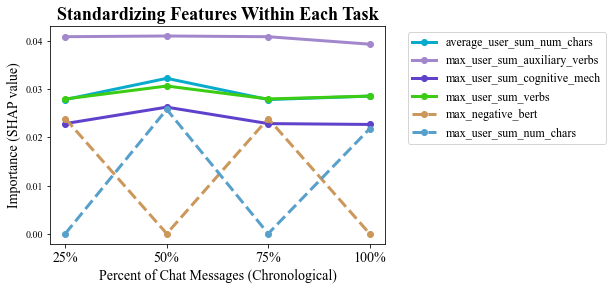

In [30]:
plot_important_features_over_time(merged_df, color_mapping, "Standardizing Features Within Each Task", "./figures/across_task_std_within_features.svg")

In [31]:
# look at direction of impact
pd.concat([joint_sw_shap_cor_means25, joint_sw_shap_cor_means50, joint_sw_shap_cor_means75, joint_sw_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
max_user_sum_auxiliary_verbs,-0.729542,-0.729992,-0.729542,-0.740981
max_user_sum_verbs,-0.733180,-0.728408,-0.733180,-0.683198
average_user_sum_num_chars,-0.724044,-0.736084,-0.724044,-0.717359
max_negative_bert,-0.743557,-0.713101,-0.743557,-0.789191
max_user_sum_cognitive_mech,-0.695801,-0.714473,-0.695801,-0.699875
max_user_sum_num_chars,-0.681502,-0.661861,-0.681502,-0.607572
average_user_sum_cognitive_mech,-0.798290,-0.793453,-0.798290,-0.804043
average_user_sum_verbs,-0.696292,-0.715441,-0.696292,-0.729865
min_textblob_subjectivity,0.672932,NaN,0.672932,0.708271


## Performance Summary (Across and Within; Train and Validation)

In [35]:
joint_btwn_metrics_train = pd.concat([joint_train_means25, joint_train_means50, joint_train_means75, joint_train_means], keys = time_points, axis=1) 
joint_within_metrics_train = pd.concat([joint_sw_train_means25, joint_sw_train_means50, joint_sw_train_means75, joint_sw_train_means], keys = time_points, axis=1)
joint_btwn_metrics_test = pd.concat([joint_test_means25, joint_test_means50, joint_test_means75, joint_test_means], keys = time_points, axis=1) 
joint_within_metrics_test = pd.concat([joint_sw_test_means25, joint_sw_test_means50, joint_sw_test_means75, joint_sw_test_means], keys = time_points, axis=1)

In [37]:
joint_within_metrics_test

,25%,50%,75%,100%
r2,0.16626,0.17121,0.16626,0.13723
mae,0.63807,0.63429,0.63807,0.64865
mse,0.75182,0.74736,0.75182,0.77682
rmse,0.86521,0.86263,0.86521,0.87974


In [33]:
def plot_r2_without_broken_axis(datasets, dataset_names, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Define line styles and colors from Dark2 colormap
    num_colors = len(dataset_names)
    colors = mpl.cm.Set2(np.linspace(0, 1, num_colors))

    # Plot datasets on the same y-axis
    for i, dataset in enumerate(datasets):
        dataset_name = dataset_names[i]
        transposed_data = dataset.T

        # Plot R^2 values for each dataset
        ax.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[i], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Adjust layout and labels
    ax.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax.set_ylabel("R^2", fontsize=16)
    ax.set_xlabel("Percent of Chat Messages (Chronological)", fontsize=16)

    # Add legend to the right
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1))

    # Set y-axis range with a buffer
    ax.set_ylim(-0.3, max(ax.get_ylim()) * 1.1)

    # Adjust title position
    plt.title(title, fontweight="bold", fontsize=18)

    # Adjust layout
    plt.tight_layout()
    plt.savefig('./figures/all_task_r2_graph.svg', dpi=1200, bbox_inches='tight')
    plt.show()

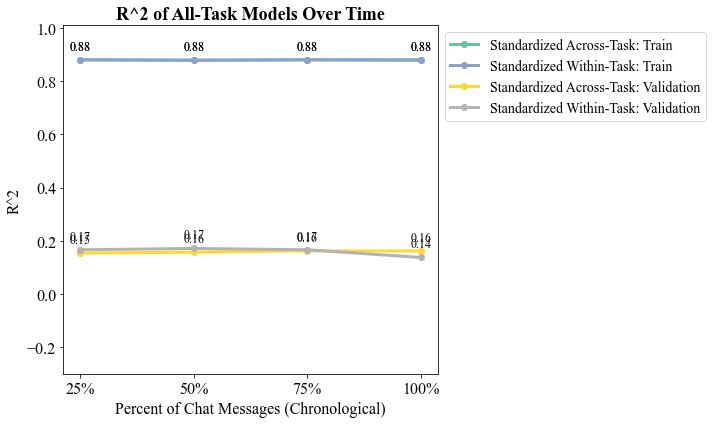

In [34]:
datasets = [joint_btwn_metrics_train, joint_within_metrics_train, joint_btwn_metrics_test, joint_within_metrics_test]
dataset_names = ["Standardized Across-Task: Train", "Standardized Within-Task: Train", "Standardized Across-Task: Validation", "Standardized Within-Task: Validation"]

plot_r2_without_broken_axis(datasets, dataset_names, "R^2 of All-Task Models Over Time")